In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score

In [2]:
"""Read in and handle data so that it is consistent with data found in logorithmic regression file"""
# Read in multiple file for combination
filenames = ["results", "goalscorers", "shootouts"]
dataframes = {}
for filename in filenames:
    df = pd.read_csv(f"../Data/{filename}.csv")
    dataframes[filename] = df

# join the files
results = dataframes["results"].join(dataframes["shootouts"].set_index(["date", "home_team", "away_team"]), on=["date", "home_team", "away_team"])
results = results.join(dataframes["goalscorers"].set_index(["date", "home_team", "away_team"]), on=["date", "home_team", "away_team"])

# covert data types
results["neutral"] = results["neutral"].astype("int")
results["own_goal"] = (results["own_goal"] == True).astype("int")
results["penalty"] = (results["penalty"] == True).astype("int")
results["first_shooter"] = (results["first_shooter"] == results["home_team"]).astype("int")

# add new fields
results["draw"] = (results["home_score"] == results["away_score"]).astype("int")
results["home_victory"] = (results["home_score"] > results["away_score"]).astype("int")
results["shootout_required"] = (results["winner"].notnull()).astype("int")

# modify added fields to reflect data interaction
results.loc[results["home_team"] == results["winner"], "home_victory"] = 1
results.loc[results["winner"].notnull(), "draw"] = 0

# remove superfluous data
results = results.drop(columns=["date", "city", "country", "winner", "team", "scorer", "minute"])

# one hot encode dummy data for categorical columns
dummied_results = pd.get_dummies(results, columns=["home_team"])
dummied_results = pd.get_dummies(dummied_results, columns=["away_team"])
dummied_results = pd.get_dummies(dummied_results, columns=["tournament"])

# Set an arbitrary significance level and drop all columns that don't meet this level
SIG_LEVEL = .05

significant = []
for col in dummied_results.columns:
    if np.abs(np.corrcoef(dummied_results["home_victory"], dummied_results[col])[0,1]) > SIG_LEVEL:
        significant.append(col)

df = dummied_results[significant]

#  Display dataset info
print("\n Dataset Overview:\n")
df.info()


 Dataset Overview:

<class 'pandas.core.frame.DataFrame'>
Index: 77966 entries, 0 to 47979
Data columns (total 23 columns):
 #   Column                   Non-Null Count  Dtype
---  ------                   --------------  -----
 0   home_score               77966 non-null  int64
 1   away_score               77966 non-null  int64
 2   neutral                  77966 non-null  int64
 3   draw                     77966 non-null  int64
 4   home_victory             77966 non-null  int64
 5   home_team_Andorra        77966 non-null  bool 
 6   home_team_Argentina      77966 non-null  bool 
 7   home_team_Brazil         77966 non-null  bool 
 8   home_team_Liechtenstein  77966 non-null  bool 
 9   home_team_Luxembourg     77966 non-null  bool 
 10  home_team_Malta          77966 non-null  bool 
 11  home_team_San Marino     77966 non-null  bool 
 12  home_team_Spain          77966 non-null  bool 
 13  away_team_Brazil         77966 non-null  bool 
 14  away_team_Cyprus         77966 non-nul

In [3]:
# ---  DEFINE FEATURES & TARGET ---
X = df.drop(columns=["home_victory"])
y = df["home_victory"]

#  Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

#  Double-check column names to avoid Patsy formula syntax errors
print("\n Final Column Names for Model:")
print(X_train.columns)


 Final Column Names for Model:
Index(['home_score', 'away_score', 'neutral', 'draw', 'home_team_Andorra',
       'home_team_Argentina', 'home_team_Brazil', 'home_team_Liechtenstein',
       'home_team_Luxembourg', 'home_team_Malta', 'home_team_San Marino',
       'home_team_Spain', 'away_team_Brazil', 'away_team_Cyprus',
       'away_team_England', 'away_team_Germany', 'away_team_Liechtenstein',
       'away_team_Luxembourg', 'away_team_Malta', 'away_team_San Marino',
       'away_team_Spain', 'tournament_Friendly'],
      dtype='object')


In [4]:
# ---  TRAIN GLM MODEL ---
#  Ensure all column names are properly enclosed in Q() to avoid syntax errors
glm_formula = "home_victory ~ " + " + ".join([f"Q('{col}')" for col in X_train.columns])

glm_model = smf.glm(formula=glm_formula,
                     data=df,
                     family=sm.families.Binomial()).fit()

#  Display GLM Model Summary
print("\n GLM Model Summary:")
print(glm_model.summary())


 GLM Model Summary:
                 Generalized Linear Model Regression Results                  
Dep. Variable:           home_victory   No. Observations:                77966
Model:                            GLM   Df Residuals:                    77943
Model Family:                Binomial   Df Model:                           22
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -576.93
Date:                Thu, 13 Feb 2025   Deviance:                       1153.9
Time:                        21:58:59   Pearson chi2:                 1.95e+04
No. Iterations:                    28   Pseudo R-squ. (CS):             0.7453
Covariance Type:            nonrobust                                         
                                           coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------

In [5]:
#  Predict with GLM Model
y_pred_glm_prob = glm_model.predict(X_test)
y_pred_glm_class = (y_pred_glm_prob > 0.5).astype(int)

#  Evaluate GLM Model
glm_accuracy = accuracy_score(y_test, y_pred_glm_class)
glm_roc_auc = roc_auc_score(y_test, y_pred_glm_prob)
glm_conf_matrix = confusion_matrix(y_test, y_pred_glm_class)

print("\n GLM Model Performance:")
print(f"✔ Accuracy: {glm_accuracy:.4f}")
print(f"✔ ROC AUC: {glm_roc_auc:.4f}")
print("✔ Confusion Matrix:\n", glm_conf_matrix)


 GLM Model Performance:
✔ Accuracy: 0.9946
✔ ROC AUC: 0.9999
✔ Confusion Matrix:
 [[7284   39]
 [  45 8226]]


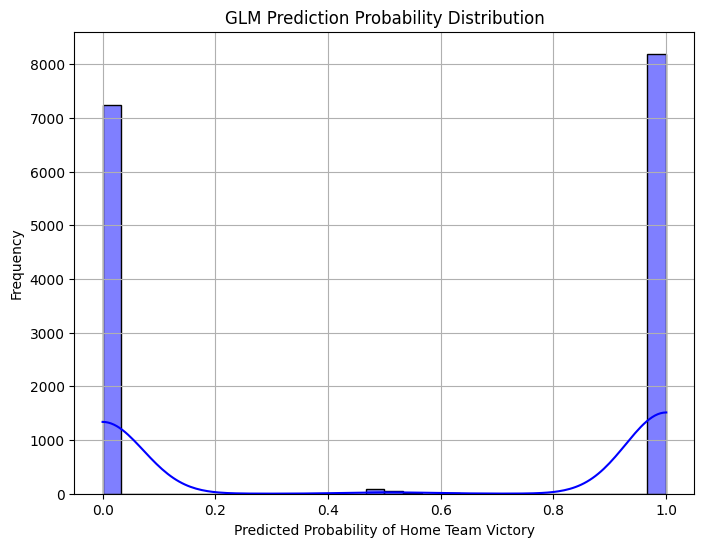

In [6]:
# ---  GLM Visualization ---
plt.figure(figsize=(8, 6))
sns.histplot(y_pred_glm_prob, kde=True, bins=30, color="blue")
plt.xlabel("Predicted Probability of Home Team Victory")
plt.ylabel("Frequency")
plt.title("GLM Prediction Probability Distribution")
plt.grid(True)
plt.show()